# LDA Klasifikasi Berita

**Tujuan**: Klasifikasi berita berdasarkan kategori menggunakan fitur topik LDA.

**Alur**: Setup → Preprocessing → LDA → Klasifikasi SVM → Visualisasi UMAP

**Dataset**: `hasil_preprocessing_berita.csv` (isi, hasil_preprocessing, kategori)

## SETUP

Import library: pandas, gensim (LDA), sklearn (klasifikasi), matplotlib, umap (visualisasi)


In [1]:
## SETUP

# Import library dasar
import pandas as pd
import numpy as np
import time

# Import untuk LDA & Koherensi
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore, CoherenceModel, HdpModel

# Import untuk Klasifikasi & Evaluasi
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Import untuk Visualisasi
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib import cm
from matplotlib.lines import Line2D
import umap.umap_ as umap

print("Semua library berhasil diimpor.")



Semua library berhasil diimpor.


## PEMUATAN DATA

Baca dataset CSV yang sudah dipreprocessing. Kolom: isi, hasil_preprocessing, kategori


In [2]:
# Memuat Dataset 
try:
    df = pd.read_csv('hasil_preprocessing_berita.csv')
    print(f"\nDataset berhasil dimuat. Jumlah data: {len(df)} baris.")
    print("Contoh kolom inti:")
    print(df[['isi', 'hasil_preprocessing', 'kategori']].head())
except FileNotFoundError:
    print("\nError: File tidak ditemukan. Pastikan nama file CSV sudah benar.")
    # Jika file tidak ditemukan, hentikan proses.
    # df = pd.DataFrame()


Dataset berhasil dimuat. Jumlah data: 1600 baris.
Contoh kolom inti:
                                                 isi  \
0  Wakil Ketua DPRSufmi Dasco Ahmadmengungkap isi...   
1  Jaksa Penuntut Umum (JPU) menuntut majelis hak...   
2  Menteri KebudayaanFadli Zonmembeberkan rencana...   
3  Sebanyak tiga purnawirawan TNI/Polri bergabung...   
4  AktorAmmar Zonikembali terlibat dalam kasus pe...   

                                 hasil_preprocessing  kategori  
0  ['wakil', 'ketua', 'dprsufmi', 'dasco', 'ahmad...  nasional  
1  ['jaksa', 'tuntut', 'jpu', 'tuntut', 'majelis'...  nasional  
2  ['menteri', 'kebudayaanfadli', 'zonmembeberkan...  nasional  
3  ['purnawirawan', 'tnipolri', 'gabung', 'dalamk...  nasional  
4  ['aktorammar', 'zonikembali', 'libat', 'edar',...  nasional  


## EKSTRAKSI FITUR LDA & PENCARIAN TOPIK OPTIMAL

1. Gabungkan kategori regional Jatim
2. Konversi hasil_preprocessing ke format token
3. Filter kamus (buang kata jarang/sering)
4. Estimasi jumlah topik dengan HDP
5. Cari topik optimal dengan koherensi
6. Ekstrak fitur distribusi topik



--- Memulai Penggabungan Kategori ---
Jumlah kategori setelah digabungkan: 8

--- Memulai Konversi Hasil Preprocessing ---
Konversi hasil preprocessing selesai.

Kamus dibuat dan difilter. Jumlah kata unik: 2249

--- Menjalankan HDP untuk estimasi jumlah topik... ---
✅ HDP mengestimasi ada sekitar: 20 topik.

--- Menjalankan pencarian koherensi dari 15 hingga 26 topik... ---
Selesai menghitung untuk 15 topik. Skor Koherensi: 0.5497
Selesai menghitung untuk 16 topik. Skor Koherensi: 0.5597
Selesai menghitung untuk 17 topik. Skor Koherensi: 0.5695
Selesai menghitung untuk 18 topik. Skor Koherensi: 0.5446
Selesai menghitung untuk 19 topik. Skor Koherensi: 0.5190
Selesai menghitung untuk 20 topik. Skor Koherensi: 0.5139
Selesai menghitung untuk 21 topik. Skor Koherensi: 0.5201
Selesai menghitung untuk 22 topik. Skor Koherensi: 0.4949
Selesai menghitung untuk 23 topik. Skor Koherensi: 0.5313
Selesai menghitung untuk 24 topik. Skor Koherensi: 0.5035
Selesai menghitung untuk 25 topik. Skor K

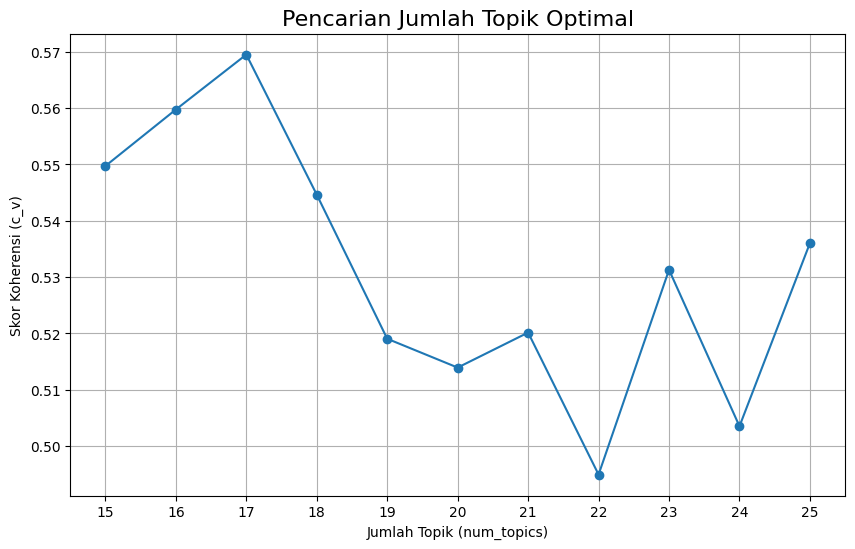


✅ Jumlah topik optimal yang ditemukan: 17

--- Melatih model LDA final dengan topik optimal... ---

--- Topik-topik yang Ditemukan oleh Model LDA ---
Topik: 0
Kata-kata: 0.023*"makan" + 0.017*"sehat" + 0.013*"konsumsi" + 0.013*"tubuh" + 0.012*"kandung" + 0.011*"minum" + 0.011*"tingkat" + 0.011*"air" + 0.010*"bantu" + 0.010*"orang" + 0.009*"lemak" + 0.009*"darah" + 0.009*"sakit" + 0.008*"gula" + 0.008*"risiko"

Topik: 1
Kata-kata: 0.025*"film" + 0.012*"cinta" + 0.012*"the" + 0.011*"tayang" + 0.011*"tampil" + 0.009*"hidup" + 0.009*"dunia" + 0.009*"tulis" + 0.008*"balap" + 0.008*"tonton" + 0.008*"bintang" + 0.008*"of" + 0.007*"cnn" + 0.007*"cerita" + 0.007*"indonesia"

Topik: 2
Kata-kata: 0.033*"malaysia" + 0.030*"hukum" + 0.025*"main" + 0.025*"fifa" + 0.021*"dokumen" + 0.020*"fam" + 0.018*"putus" + 0.018*"palsu" + 0.014*"tujuh" + 0.013*"hakim" + 0.012*"naturalisasi" + 0.012*"penjara" + 0.011*"kait" + 0.011*"banding" + 0.010*"adil"

Topik: 3
Kata-kata: 0.035*"rp" + 0.020*"harga" + 0.012*

In [3]:
## EKSTRAKSI FITUR LDA & PENCARIAN TOPIK OPTIMAL

# --- A. Penggabungan Kategori (Opsional, tapi Sangat Direkomendasikan) ---
print("\n--- Memulai Penggabungan Kategori ---")
mapping_kategori = {
    'Jatim': 'Berita Regional Jatim', 'Jatim Barat': 'Berita Regional Jatim',
    'Jatim Madura': 'Berita Regional Jatim', 'Jatim Metro': 'Berita Regional Jatim',
    'Jatim Selatan': 'Berita Regional Jatim', 'Jatim Tengah': 'Berita Regional Jatim',
    'Jatim Timur': 'Berita Regional Jatim', 'Jatim Utara': 'Berita Regional Jatim'
}
df['kategori'] = df['kategori'].replace(mapping_kategori)
print(f"Jumlah kategori setelah digabungkan: {df['kategori'].nunique()}")

# --- B. Konversi hasil_preprocessing ke format token ---
print("\n--- Memulai Konversi Hasil Preprocessing ---")
from ast import literal_eval

def ensure_tokens(value):
    if isinstance(value, list):
        return value
    if isinstance(value, str):
        text = value.strip()
        # Jika tampak seperti list Python
        if text.startswith('[') and text.endswith(']'):
            try:
                lst = literal_eval(text)
                return [str(tok) for tok in lst]
            except Exception:
                pass
        # Fallback: anggap string token dipisah spasi
        return [tok for tok in text.split() if tok]
    # Fallback untuk nilai non-string/non-list
    return []

# Buat kolom tokens langsung dari hasil_preprocessing
df['tokens'] = df['hasil_preprocessing'].apply(ensure_tokens)
print("Konversi hasil preprocessing selesai.")

# Siapkan data untuk Gensim
documents = df['tokens'].tolist()
dictionary = Dictionary(documents)

# Filter Kamus 
# Membuang kata yang terlalu jarang atau terlalu sering muncul.
# Ini meningkatkan kualitas topik secara signifikan.
dictionary.filter_extremes(no_below=15, no_above=0.5)
corpus = [dictionary.doc2bow(doc) for doc in documents]
print(f"\nKamus dibuat dan difilter. Jumlah kata unik: {len(dictionary)}")


# Estimasi Jumlah Topik dengan HDP 
print("\n--- Menjalankan HDP untuk estimasi jumlah topik... ---")
hdp_model = HdpModel(corpus=corpus, id2word=dictionary)
estimated_num_topics = len(hdp_model.print_topics())
print(f"✅ HDP mengestimasi ada sekitar: {estimated_num_topics} topik.")


# Mencari Jumlah Topik Terbaik dengan Plot Koherensi 
def compute_coherence_values_multicore(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    start_time = time.time()
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                             random_state=42, passes=10, workers=3)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        current_coherence = coherencemodel.get_coherence()
        coherence_values.append(current_coherence)
        print(f"Selesai menghitung untuk {num_topics} topik. Skor Koherensi: {current_coherence:.4f}")
    total_time = time.time() - start_time
    print(f"\nTotal waktu pencarian koherensi: {total_time/60:.2f} menit")
    return coherence_values

# Atur rentang pencarian di sekitar hasil HDP (lebih ketat & presisi)
search_start = max(2, estimated_num_topics - 5)
search_limit = estimated_num_topics + 6
search_step = 1

print(f"\n--- Menjalankan pencarian koherensi dari {search_start} hingga {search_limit} topik... ---")
coherence_values = compute_coherence_values_multicore(dictionary=dictionary, corpus=corpus, texts=documents,
                                                    start=search_start, limit=search_limit, step=search_step)

# Tampilkan grafik
x = range(search_start, search_limit, search_step)
plt.figure(figsize=(10, 6))
plt.plot(x, coherence_values, marker='o')
plt.title("Pencarian Jumlah Topik Optimal", fontsize=16)
plt.xlabel("Jumlah Topik (num_topics)")
plt.ylabel("Skor Koherensi (c_v)")
plt.xticks(x)
plt.grid(True)
plt.show()

# Pilih jumlah topik terbaik (yang memiliki skor koherensi tertinggi)
optimal_num_topics = x[np.argmax(coherence_values)]
print(f"\n✅ Jumlah topik optimal yang ditemukan: {optimal_num_topics}")


# Latih Model LDA Final & Ekstrak Fitur ---
print("\n--- Melatih model LDA final dengan topik optimal... ---")
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=optimal_num_topics,
                         random_state=42, passes=15)

print("\n--- Topik-topik yang Ditemukan oleh Model LDA ---")
    # Tampilkan 15 kata teratas untuk setiap topik
for idx, topic in lda_model.print_topics(num_words=15):
    print(f"Topik: {idx}")
    print(f"Kata-kata: {topic}\n")

# Ekstrak fitur (distribusi topik) untuk setiap dokumen
def get_lda_features(lda_model, bow_corpus):
    features = []
    for doc_bow in bow_corpus:
        topic_distribution = lda_model.get_document_topics(doc_bow, minimum_probability=0)
        doc_features = [0.0] * optimal_num_topics
        for topic_id, prob in topic_distribution:
            doc_features[topic_id] = prob
        features.append(doc_features)
    return np.array(features)

X = get_lda_features(lda_model, corpus)
y = df['kategori'].values

print("Ekstraksi fitur LDA selesai.")
print(f"Bentuk matriks fitur (X): {X.shape}")

## PELATIHAN DAN EVALUASI MODEL KLASIFIKASI

1. Split data 80/20 dengan stratifikasi
2. Latih SVM kernel linear
3. Evaluasi dengan akurasi dan classification report


In [4]:
## PELATIHAN DAN EVALUASI MODEL KLASIFIKASI

# Bagi Data menjadi Latih dan Uji ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nData dibagi. Jumlah data latih: {len(X_train)}, Jumlah data uji: {len(X_test)}")


# Latih Model Klasifikasi (SVM) 
classifier = SVC(kernel='linear', random_state=42, probability=True)

print("\n--- Memulai pelatihan model SVM... ---")
classifier.fit(X_train, y_train)
print("Pelatihan selesai.")


# Evaluasi Kinerja Model
y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\n--- HASIL EVALUASI AKHIR ---")
print(f"Akurasi Model: {accuracy * 100:.2f}%")
print("\nLaporan Klasifikasi (Classification Report):")
print(classification_report(y_test, y_pred))


Data dibagi. Jumlah data latih: 1280, Jumlah data uji: 320

--- Memulai pelatihan model SVM... ---
Pelatihan selesai.

--- HASIL EVALUASI AKHIR ---
Akurasi Model: 71.88%

Laporan Klasifikasi (Classification Report):
               precision    recall  f1-score   support

      ekonomi       0.62      0.72      0.67        40
   gaya-hidup       0.83      0.62      0.71        40
      hiburan       0.67      0.70      0.68        40
internasional       0.91      0.72      0.81        40
     nasional       0.61      0.70      0.65        40
     olahraga       0.90      0.88      0.89        40
     otomotif       0.74      0.65      0.69        40
    teknologi       0.61      0.75      0.67        40

     accuracy                           0.72       320
    macro avg       0.74      0.72      0.72       320
 weighted avg       0.74      0.72      0.72       320



## ANALISIS LANJUTAN DAN VISUALISASI (UMAP)

1. Turunkan dimensi fitur ke 2D dengan UMAP
2. Visualisasi scatter plot train vs test
3. Color coding per kategori untuk melihat pemisahan



--- Membuat visualisasi UMAP untuk perbandingan Train vs Test... ---


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\User\AppData\Local\Temp\ipykernel_13828\1922531978.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("Spectral", len(labels))


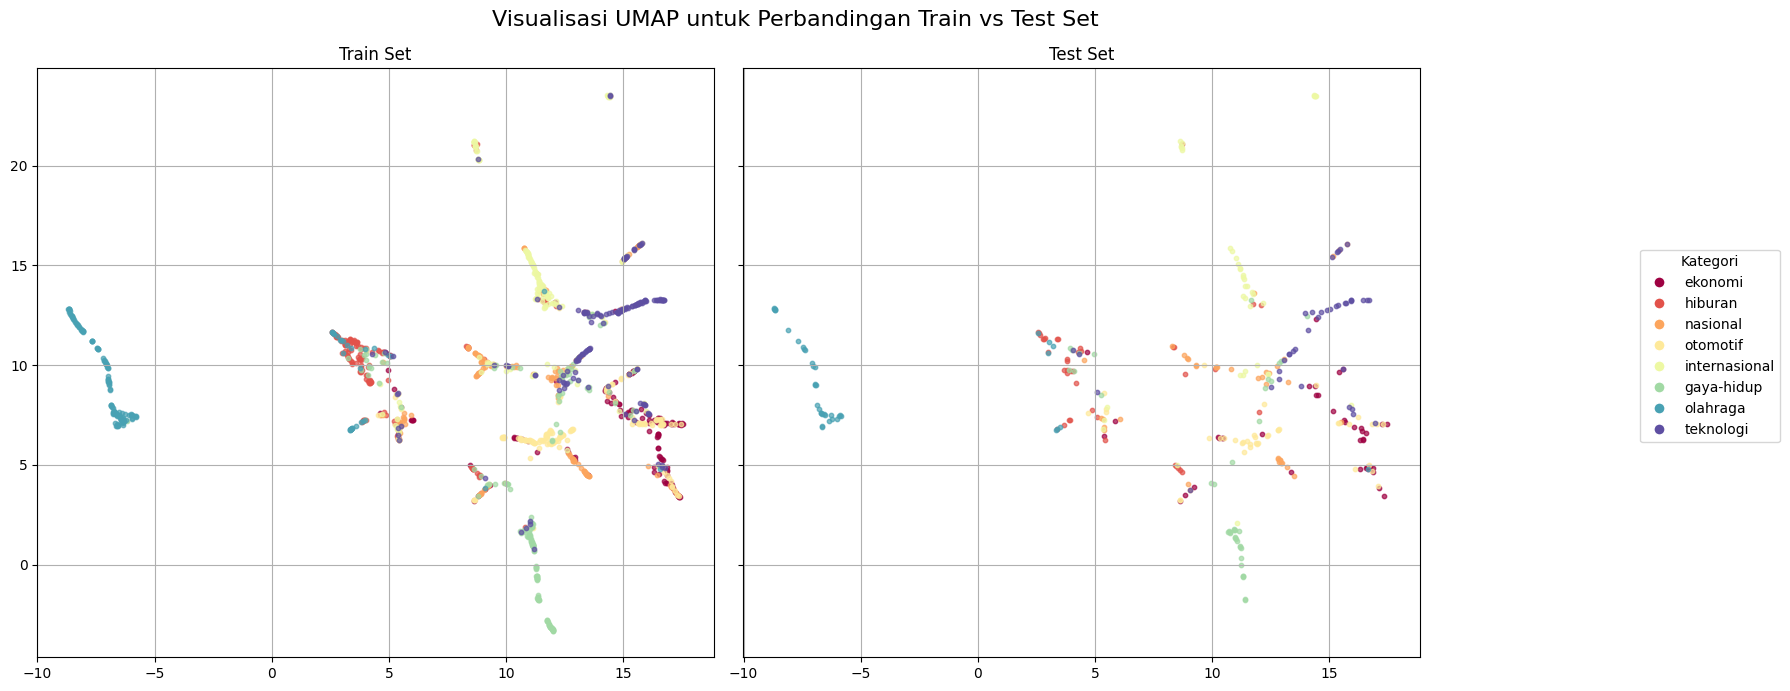


--- Selesai ---


In [5]:
## ANALISIS LANJUTAN DAN VISUALISASI (UMAP)

print("\n--- Membuat visualisasi UMAP untuk perbandingan Train vs Test... ---")

# Siapkan Data untuk Visualisasi 
labels = list(pd.Series(y_train).unique())
label_map = {label: i for i, label in enumerate(labels)}
y_train_numeric = pd.Series(y_train).map(label_map).values
y_test_numeric = pd.Series(y_test).map(label_map).values

# Gabungkan, skalakan, dan terapkan UMAP
X_combined = np.concatenate((X_train, X_test), axis=0)
X_scaled = StandardScaler().fit_transform(X_combined)
reducer = umap.UMAP(n_components=2, random_state=42)
X_2d_combined = reducer.fit_transform(X_scaled)
x2d_train = X_2d_combined[:len(X_train)]
x2d_test = X_2d_combined[len(X_train):]

fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharex=True, sharey=True)
colors = cm.get_cmap("Spectral", len(labels))

axes[0].set_title("Train Set")
for i, label_name in enumerate(labels):
    axes[0].scatter(x2d_train[y_train_numeric == i, 0], x2d_train[y_train_numeric == i, 1], 
                    color=colors(i / len(labels)), alpha=0.7, s=10)
axes[0].grid(True)

axes[1].set_title("Test Set")
for i, label_name in enumerate(labels):
    axes[1].scatter(x2d_test[y_test_numeric == i, 0], x2d_test[y_test_numeric == i, 1], 
                    color=colors(i / len(labels)), alpha=0.7, s=10)
axes[1].grid(True)

fig.suptitle("Visualisasi UMAP untuk Perbandingan Train vs Test Set", fontsize=16)

# Buat handle legenda secara manual
legend_handles = [Line2D([0], [0], marker='o', color='w', label=label,
                            markerfacecolor=colors(i / len(labels)), markersize=8)
                    for i, label in enumerate(labels)]

fig.legend(handles=legend_handles, title="Kategori", loc='center right', bbox_to_anchor=(1.12, 0.5))

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

print("\n--- Selesai ---")